In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# Ustawienia wyświetlania wykresów
%matplotlib inline

# Pobranie danych od 01-01-2019 do 31-12-2021
df = yf.download('ETH-USD', start='2019-01-01', end='2021-12-31')

# Użyjemy tylko kolumny 'Close' jako cechy
data = df[['Close']].values

data

[*********************100%***********************]  1 of 1 completed


array([[ 140.81941223],
       [ 155.04768372],
       [ 149.13500977],
       ...,
       [3800.89306641],
       [3628.53173828],
       [3713.85205078]])

In [13]:
# Skalowanie danych do zakresu (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)
# Definiowanie funkcji do tworzenia sekwencji danych
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Tworzenie sekwencji z look_back = 60 dni
look_back = 60
X, Y = create_dataset(scaled_data, look_back)




[[0.00770764]
 [0.01073007]
 [0.00947408]
 ...
 [0.78519742]
 [0.74858363]
 [0.76670776]]


In [12]:
# Reshape danych wejściowych do formatu [próbki, timesteps, cechy]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Podział na zbiór treningowy i testowy (80% treningowy, 20% walidacyjny)
train_size = int(len(X) * 0.7)
X_train, X_val = X[:train_size], X[train_size:]
Y_train, Y_val = Y[:train_size], Y[train_size:]



[[[0.00770764]
  [0.01073007]
  [0.00947408]
  ...
  [0.00671063]
  [0.0068424 ]
  [0.00677811]]

 [[0.01073007]
  [0.00947408]
  [0.01063114]
  ...
  [0.0068424 ]
  [0.00677811]
  [0.00630299]]

 [[0.00947408]
  [0.01063114]
  [0.0108556 ]
  ...
  [0.00677811]
  [0.00630299]
  [0.00588716]]

 ...

 [[0.91559502]
  [0.8966688 ]
  [0.88868669]
  ...
  [0.84730782]
  [0.84179479]
  [0.83546867]]

 [[0.8966688 ]
  [0.88868669]
  [0.8964514 ]
  ...
  [0.84179479]
  [0.83546867]
  [0.78519742]]

 [[0.88868669]
  [0.8964514 ]
  [0.95171831]
  ...
  [0.83546867]
  [0.78519742]
  [0.74858363]]]


In [5]:
# Budowa modelu GRU
model = Sequential()
model.add(GRU(units=256, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(GRU(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

# Kompilacja modelu
model.compile(loss='mean_squared_error', optimizer='adam')

# Trenowanie modelu z walidacją
history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_data=(X_val, Y_val), verbose=1)



C:\Users\Michał\Desktop\crypto_predict\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 256)        │       198,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 60, 128)        │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,035 (1.47 MB)

 Trainable params: 386,035 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 289ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - loss: 3.5824e-04 - val_loss: 0.0073
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 1.5189e-04 - val_loss: 0.0029
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 1.3074e-04 - val_loss: 0.0025
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 1.3705e-04 - val_loss: 0.0030


In [6]:
# Predykcja na zbiorze walidacyjnym
predicted_val = model.predict(X_val)
predicted_val = scaler.inverse_transform(predicted_val)
Y_val_inverse = scaler.inverse_transform(Y_val.reshape(-1, 1))

# Pobranie dat dla zbioru walidacyjnego
validation_dates = df.index[look_back + train_size:]



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


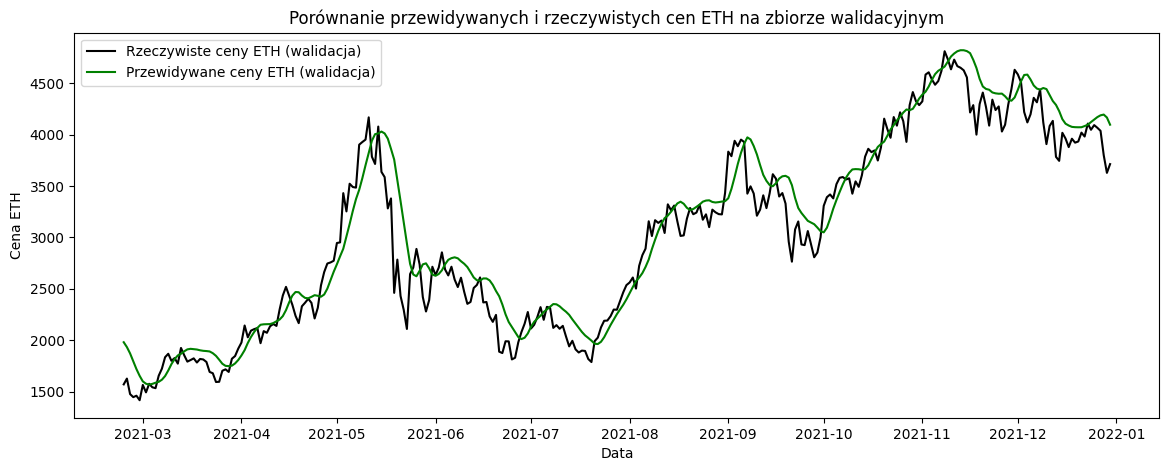

In [7]:
# Wykres porównujący na zbiorze walidacyjnym
plt.figure(figsize=(14,5))
plt.plot(validation_dates, Y_val_inverse, color='black', label='Rzeczywiste ceny ETH (walidacja)')
plt.plot(validation_dates, predicted_val, color='green', label='Przewidywane ceny ETH (walidacja)')
plt.title('Porównanie przewidywanych i rzeczywistych cen ETH na zbiorze walidacyjnym')
plt.xlabel('Data')
plt.ylabel('Cena ETH')
plt.legend()
plt.show()



In [8]:
# Pobranie nowych danych dla okresu od 2022-01-01 do 2022-03-31
test_data = yf.download('ETH-USD', start='2022-01-01', end='2022-03-31')
actual_prices = test_data[['Close']].values

# Użycie danych do 31-12-2021, które są już w zmiennej df
train_close = df[['Close']].values

# Łączenie danych treningowych i testowych w celu utrzymania ciągłości
total_dataset = np.concatenate((train_close, actual_prices), axis=0)



[*********************100%***********************]  1 of 1 completed


In [9]:
# Przygotowanie danych do predykcji
inputs = total_dataset[len(total_dataset) - len(actual_prices) - look_back:]
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

# Tworzenie sekwencji danych do predykcji
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


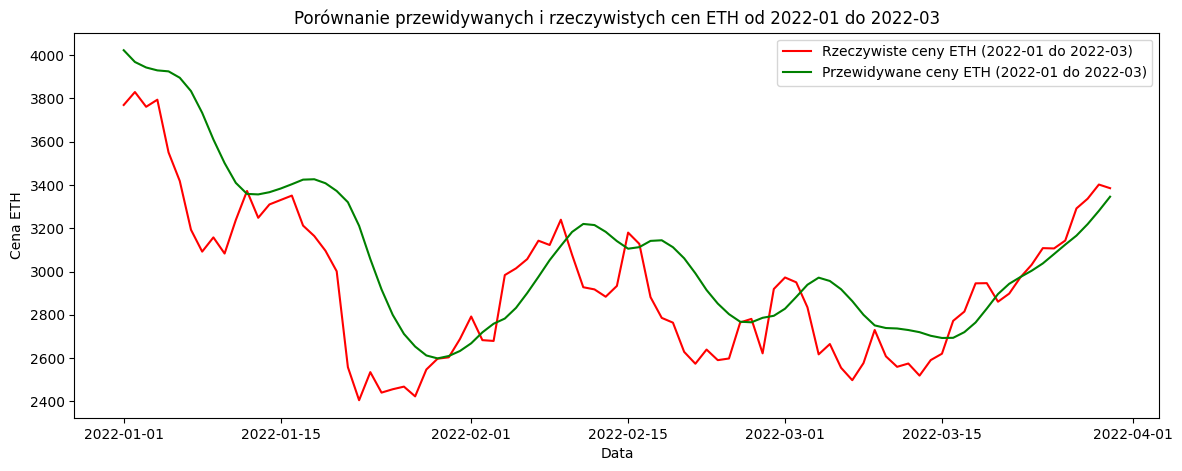

In [10]:
# Predykcja cen od 2022-01-01 do 2022-03-31
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Rzeczywiste ceny zamknięcia dla tego okresu
real_prices = test_data['Close'].values

# Daty dla okresu predykcji
test_dates = test_data.index

# Wykres porównujący rzeczywiste ceny z przewidywanymi
plt.figure(figsize=(14,5))
plt.plot(test_dates, real_prices, color='red', label='Rzeczywiste ceny ETH (2022-01 do 2022-03)')
plt.plot(test_dates, predicted_prices, color='green', label='Przewidywane ceny ETH (2022-01 do 2022-03)')
plt.title('Porównanie przewidywanych i rzeczywistych cen ETH od 2022-01 do 2022-03')
plt.xlabel('Data')
plt.ylabel('Cena ETH')
plt.legend()
plt.show()